In [1]:
from config import get_args
from tqdm import tqdm
from model import *
from data_loader import PushDataLoader
from pixyz_utils import save_model,load_model
from torch.utils.tensorboard import SummaryWriter
import torch
import os

In [2]:
args = get_args(jupyter=True, args=["--model", "SSM16", "--s_dim", "64", "512", "--epoch", "1"])
print(args)

Namespace(B=32, T=10, a_dim=4, comment=None, data_dir='~/tensorflow_datasets/', device_ids=[0], epochs=1, gamma=1e-05, h_dim=1024, log_dir='../runs/Jan27_15-07-38_SSM16_s64-512_3042a4f', min_stddev=0.0, model='SSM16', resume=False, resume_epoch=None, resume_itr=None, resume_name=None, resume_time=None, runs_dir='../runs/', s_dim=[64, 512], seed=0)


In [3]:
device = args.device_ids[0]

SEED = args.seed
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

model = SSM(args, device)

path = os.path.join("model", "SSM", "Jan21_01-16-15")
restore_distributions = [model.priors[0], model.posteriors[0], model.encoders[0], model.decoders[0]]
for i, dist in enumerate(restore_distributions):
    dist.load_state_dict(torch.load(os.path.join(path, "dist" + str(i) + ".pt")))

path = os.path.join("model", "Jan22_03-57-33_SSM16_s64-512_ac6311e", "Jan27_07-50-02")
restore_distributions = [model.priors[1], model.posteriors[1], model.encoders[1], model.decoders[1]]
for i, dist in enumerate(restore_distributions):
    dist.load_state_dict(torch.load(os.path.join(path, "dist" + str(i) + ".pt")))

In [32]:
train_loader = PushDataLoader("train", args)
test_loader = PushDataLoader("test", args)

0


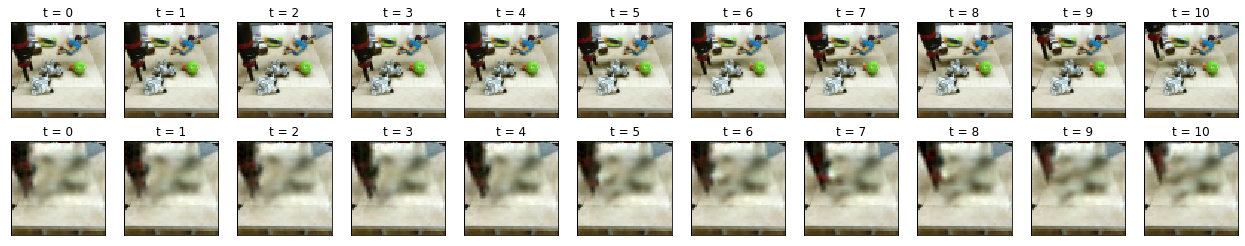

1


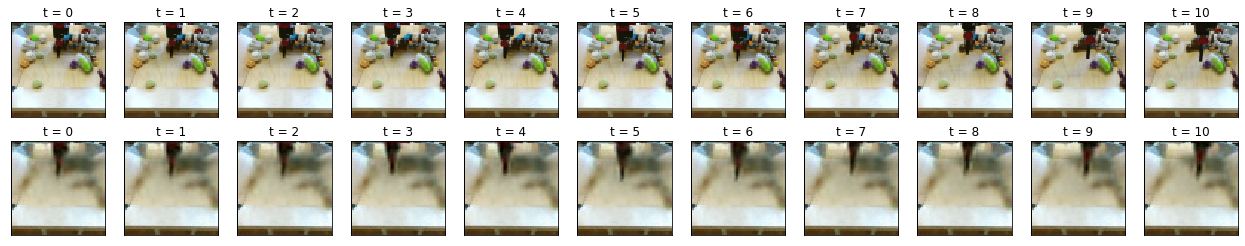

2


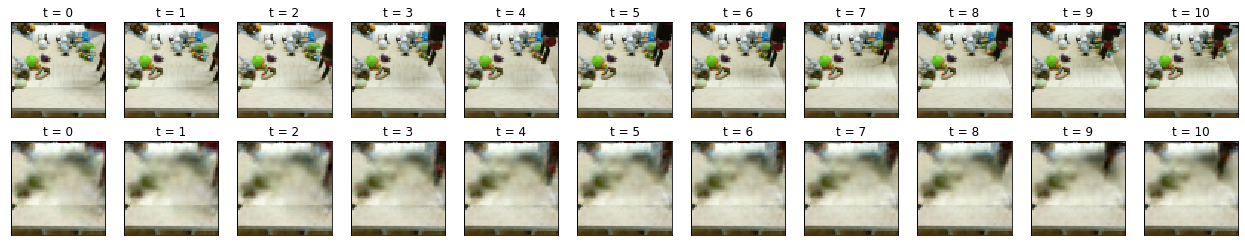

3


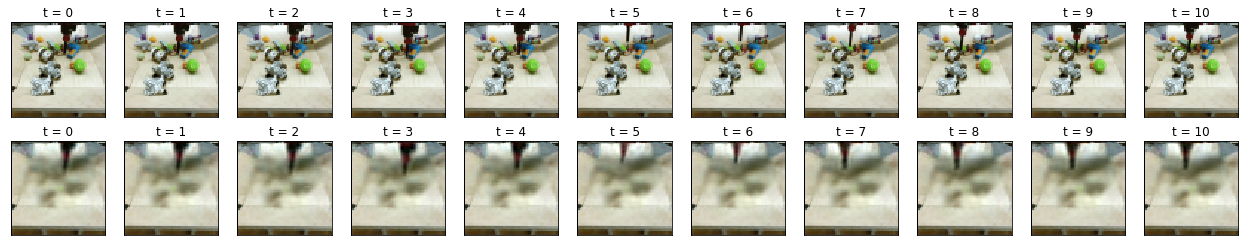

4


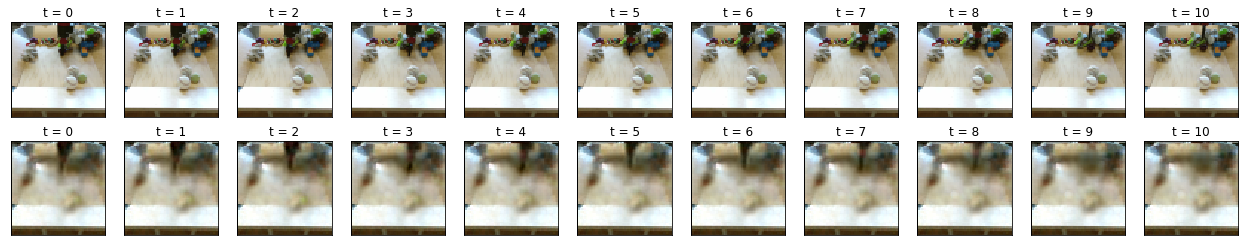

5


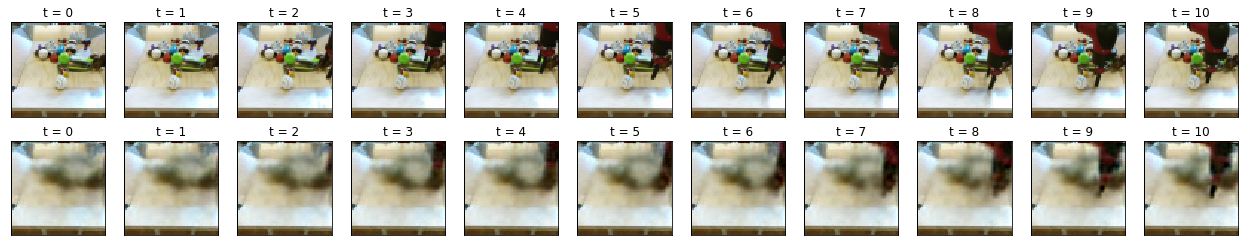

6


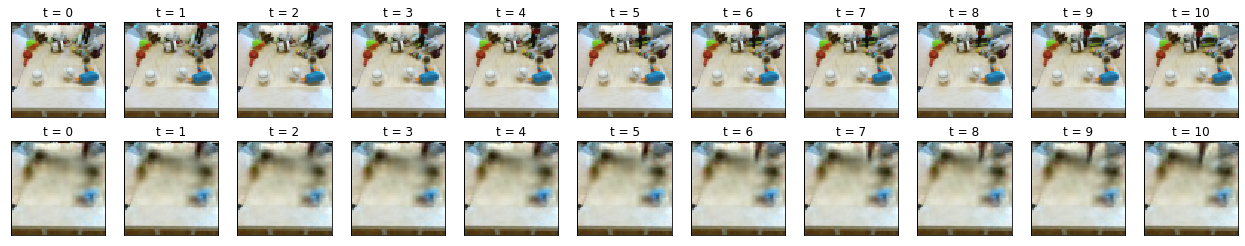

7


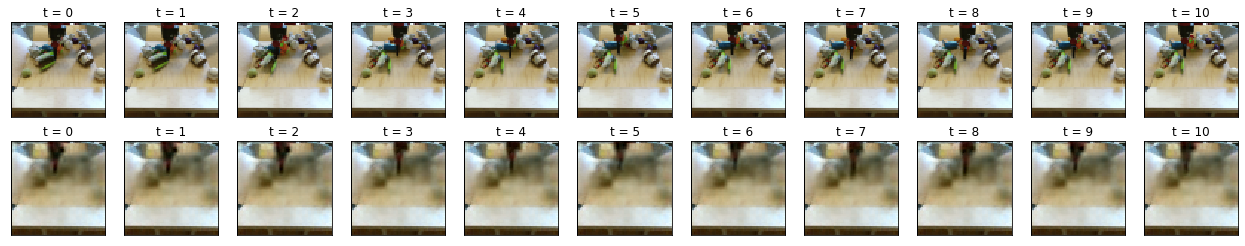

In [55]:
test_loader = PushDataLoader("test", args)

for i, batch in enumerate(test_loader):
    print(i)

    x, a, itr = batch
    _B = x.size(0)
    x = x.to(device).transpose(0, 1)  # T,B,3,28,28
    a = a.to(device).transpose(0, 1)  # T,B,1

    feed_dict = {"x0": x[0].clone(), "x": x, "a": a}
    
    video = model.sample_x(feed_dict)
    
    video = video.to("cpu").numpy()
    
    fig = plt.figure(figsize=(22, 4))

    subplot = fig.add_subplot(2, 11, 1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    plt.title("t = 0")
    subplot.imshow(video[0,0].transpose(1,2,0))
    for t in range(10):
        subplot = fig.add_subplot(2, 11, t+2)
        subplot.set_xticks([])
        subplot.set_yticks([])
        plt.title("t = {}".format(t+1))
        subplot.imshow(video[0,t].transpose(1,2,0))

    subplot = fig.add_subplot(2, 11, 12)
    subplot.set_xticks([])
    subplot.set_yticks([])
    plt.title("t = 0")
    subplot.imshow(video[8,0].transpose(1,2,0))
    for t in range(10):
        subplot = fig.add_subplot(2, 11, t+13)
        subplot.set_xticks([])
        subplot.set_yticks([])
        plt.title("t = {}".format(t+1))
        subplot.imshow(video[8,t].transpose(1,2,0))

    plt.show()

In [53]:
print(video.shape)
video = video.to("cpu").numpy()
print(video.shape)

torch.Size([64, 10, 3, 64, 64])
(64, 10, 3, 64, 64)


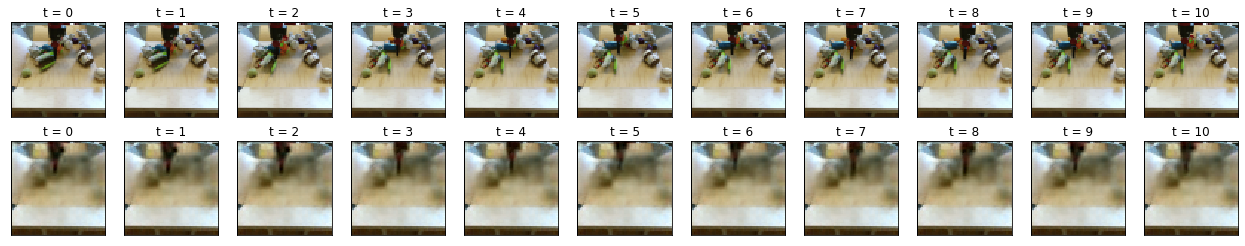

In [75]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(22, 4))

subplot = fig.add_subplot(2, 11, 1)
subplot.set_xticks([])
subplot.set_yticks([])
plt.title("t = 0")
subplot.imshow(video[0,0].transpose(1,2,0))
for t in range(10):
    subplot = fig.add_subplot(2, 11, t+2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    plt.title("t = {}".format(t+1))
    subplot.imshow(video[0,t].transpose(1,2,0))

subplot = fig.add_subplot(2, 11, 12)
subplot.set_xticks([])
subplot.set_yticks([])
plt.title("t = 0")
subplot.imshow(video[8,0].transpose(1,2,0))
for t in range(10):
    subplot = fig.add_subplot(2, 11, t+13)
    subplot.set_xticks([])
    subplot.set_yticks([])
    plt.title("t = {}".format(t+1))
    subplot.imshow(video[8,t].transpose(1,2,0))

plt.show()

In [68]:
import cv2
import numpy as np

# faster than `vread` in `skvideo.io`
def vread(path, T=30):
    cap = cv2.VideoCapture(path)
    gif = [cap.read()[1][:,:,::-1] for i in range(T)]
    gif = np.array(gif)
    cap.release()
    return gif

gif = vread("gif/s64-512_1000.gif", T=10)
print(gif.shape)

(10, 512, 512, 3)


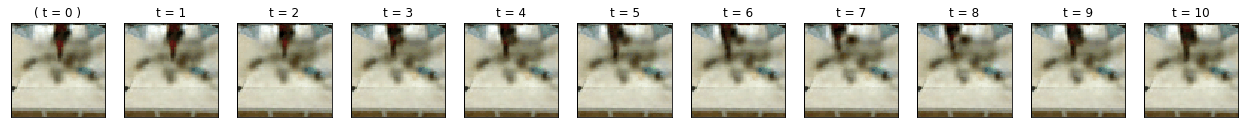

In [122]:
fig = plt.figure(figsize=(22,2))

subplot = fig.add_subplot(1, 11, 1)
subplot.set_xticks([])
subplot.set_yticks([])
plt.title("( t = 0 )")
subplot.imshow(gif[0, 64:128, 0:64])

for t in range(10):
    subplot = fig.add_subplot(1, 11, t+2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    plt.title("t = {}".format(t+1))
    subplot.imshow(gif[t, 64:128, 0:64])
path = "img/s64-512_1000_0.png"
plt.savefig(path)
plt.show()

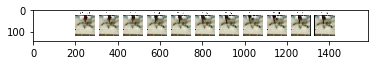

In [123]:
img = plt.imread(path)
plt.imshow(img)
plt.show()

144 1584 4


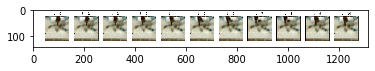

In [127]:
h, w, c = img.shape
print(h, w, c)
plt.imshow(img[:, 150:w-120, :])
plt.savefig("img/s64-512_1000_0_mini.png")
plt.show()